# PUHEKOMENNOT TUNNISTAMINEN ÄÄNITTEISTÄ
Tehtävä: Rakenna malli, joka tunnistaa yksinkertaisia puhuttuja komentoja

Aineisto: [Speech Commands Dataset](https://www.tensorflow.org/datasets/catalog/speech_commands)

#### Aineisto on ladattu ja purettu testi/treeni/validaatio setteihin aineiston mukana tulevien readme-tiedostojen mukaan:
- README tiedostossa oli kerrottu, että datasetin tiedostot kannattaa jakaa hajautusfunktiolla
- Hajautusfunktio oli erotellut tiedostot niiden nimen perusteella ja antanut listan tiedostoista, joiden tulisi olla testi, treeni, tai validaatio aineistossa.
- Kirjoitimme Python -skriptin joka luki nämä tekstitiedostossa olevat tiedostonimet ja jakoi tiedostot oikeisiin aineistoihin.

Aineisto on jos siis eroteltu etukäteen.

#### Aineisto koostuu kahdestakymmenestä sanasta, joihin koulutus keskittyy:
- "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight" ja "Nine".
- Jokaisesta sanasta esiintyy aineistossa yhden lukijan äänite viisi kertaa.

#### Lisäksi aineistossa tuli mukana luokittelut muille sanoille:
- "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila", "Tree" ja "Wow".
- Jokainen sana esiintyy yhden noin kerran jokaiselta lukijalta.
- Nämä toissijaiset sanat on yhdistetty "unknown" luokitteluun.
     - Tämä tarkoittaa, että mallin tulisi keskittyä tunnistamaan, onko annettu ääni yksi avainsanoista, vai joku muu.

Lisäksi validaatiokansiossa oli luokittelu "background noise", jonka poistimme.

## Datasetin muodostaminen
Käytetään Kerasin dataset_from_directory -metodia datasetin luomiseen.
Luokittelu tapahtuu alikansioiden nimien mukaan erittäin hienosti.

In [2]:
import tensorflow as tf
import keras
import keras.utils
import numpy as np
import pathlib

DATASET_PATH = 'split_dataset'
data_dir = pathlib.Path(DATASET_PATH)

# Load the dataset
train_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/train',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
val_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/validation',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)
test_ds = keras.utils.audio_dataset_from_directory(
    str(data_dir) + '/test',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)


Found 72593 files belonging to 26 classes.
Found 8549 files belonging to 26 classes.
Found 9500 files belonging to 26 classes.


In [2]:
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

label names: ['Unknown' 'backward' 'down' 'eight' 'five' 'follow' 'forward' 'four' 'go'
 'learn' 'left' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'six' 'stop'
 'three' 'two' 'up' 'visual' 'yes' 'zero']


Aineisto sisältää mono-audiota, mutta aineistoon tulee kaksi äänikanavaa. Poistetaan toinen.

In [3]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

Tarkastellaan opetusdatan muotoa

In [4]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)
  print(example_labels[0])  # Print the label of the first example

(32, 16000)
(32, 26)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)


Yksi batch sisältää 32 kappaletta 16000 yksikköä pitkiä äänititteitä.

Luokkia on 26 erilaista.

Luokittelut on one-hot-encodattu.

### Piirretään vähän kuvia äänistä

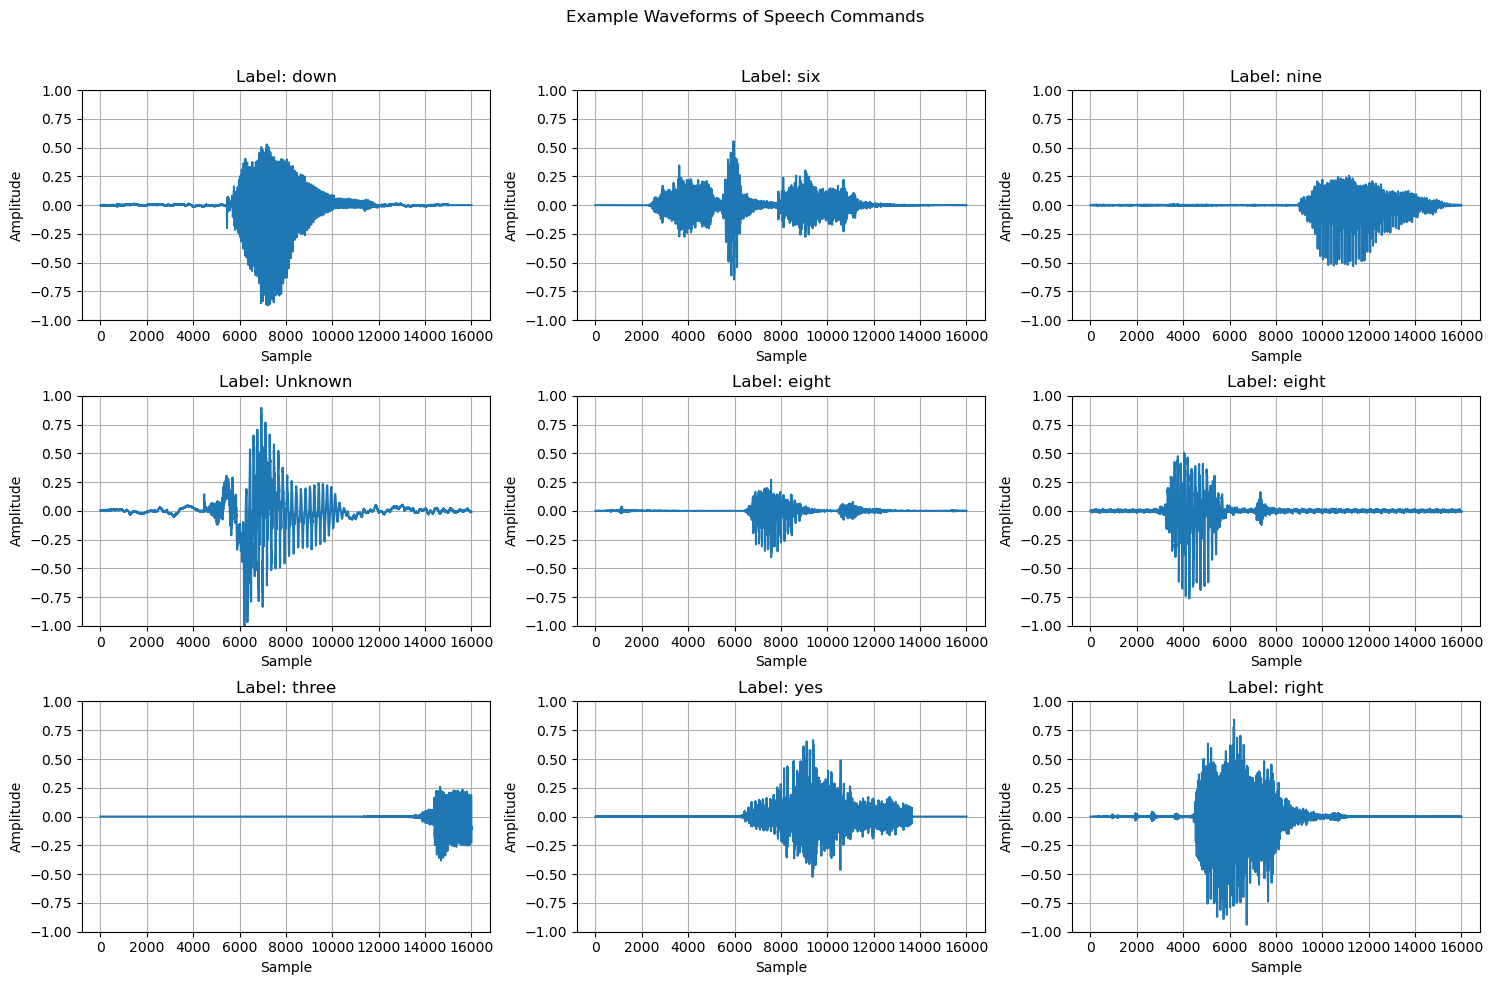

In [7]:
import matplotlib.pyplot as plt

# Function to plot waveforms with their labels
def plot_waveforms(waveforms, labels, num_rows=3, num_cols=3):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle('Example Waveforms of Speech Commands')
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    for i, (waveform, label) in enumerate(zip(waveforms, labels)):
        if i >= num_rows * num_cols:
            break
            
        # Get the label index (where the value is 1.0)
        label_idx = tf.argmax(label).numpy()
        label_name = label_names[label_idx]
        
        # Plot the waveform
        axes[i].plot(waveform.numpy())
        axes[i].set_title(f'Label: {label_name}')
        axes[i].set_ylim([-1, 1])
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot examples from the training dataset
for example_batch, example_labels in train_ds.take(1):
    plot_waveforms(example_batch, example_labels)

### Aaltomuodot (Waveform)

 - Kuvaavat äänen amplitudia, eli voimakkuutta.
 - Sekunnin mittainen näyte, jossa 16000 mitta-arvoa.
 - Värähtely, ei lukema, tarkoittaa äänen voimakkuutta.
 - Ei näytä taajuutta.

## Muutetaan aaltomallit spektogrammeiksi

### Testataan eri spektrogrammoja

<b> Spektrogramma kuvaa äänen eri taajuusalueita ja voimakkuuksia. </b>

Luodaan funktiot "tavallisen" spektrogramman ja "mel" spektrogramman tekemiseen.

Tensorflow tarjoaa singal.stft -metodin, joka muuttaa ääniaallosta spektrogramman.
 - Käyttää Fourier-muunnosta. (Muuttaa säännöllisen aallon (sini) )
 - Fourier-muunnos ei toimi muuttuvalle signaalille (puhe), joten käytetään STFT (Short-time Fourier Transform)
   - Tarkoittaa, että ääni jaetaan pieniin osiin, ja osille tehdään erikseen Fourier-muunnos.

In [26]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Mel spektrogramma on samanlainen, kuin aikaisemmin, mutta taajuudet merkitään epälineaarisesti.

Mel skaala kuvaa paremmin sitä, miltä taajuudet kuulostavat. Lisäksi se skaalataan ihmisen kuuloalueelle 0 - 8000 Hz. (Oikeastaan kuuloalue on 20 - 8000, mutta otetaan vähän isompi, ettei menetetä dataa)

In [25]:
def get_mel_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=512, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Convert to mel scale
    mel_spectrogram = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=0,             # Taajuudet 0-8000 Hz
        upper_edge_hertz=8000)          # Se on ihmisen kuuloalue
    mel_spectrogram = tf.tensordot(spectrogram, mel_spectrogram, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_spectrogram.shape[-1:]))
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    return mel_spectrogram

In [30]:
def plot_waveform_and_spectrograms(waveform):
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(waveform.numpy())
    plt.title('Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot the spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(spectrogram).numpy(), aspect='auto', cmap='hot')
    plt.title('Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency bins')
    plt.colorbar()

    # Plot the mel spectrogram
    mel_spectrogram = get_mel_spectrogram(waveform)
    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(mel_spectrogram).numpy(), aspect='auto', cmap='hot')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Mel frequency bins')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

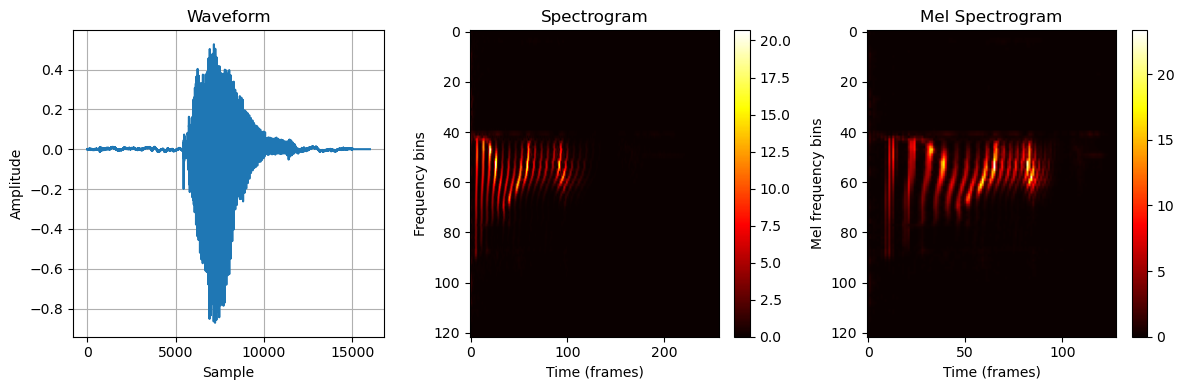

In [35]:
plot_waveform_and_spectrograms(example_batch[0])


### Muutetaan koko datasetti spektrogrammamuotoon:

In [36]:
def make_spectro_dataset(ds, spectrogram_fn):
    return ds.map(lambda audio, labels: (spectrogram_fn(audio), labels),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_spectro_ds = make_spectro_dataset(train_ds, get_mel_spectrogram)
val_spectro_ds = make_spectro_dataset(val_ds, get_mel_spectrogram)
test_spectro_ds = make_spectro_dataset(test_ds, get_mel_spectrogram)

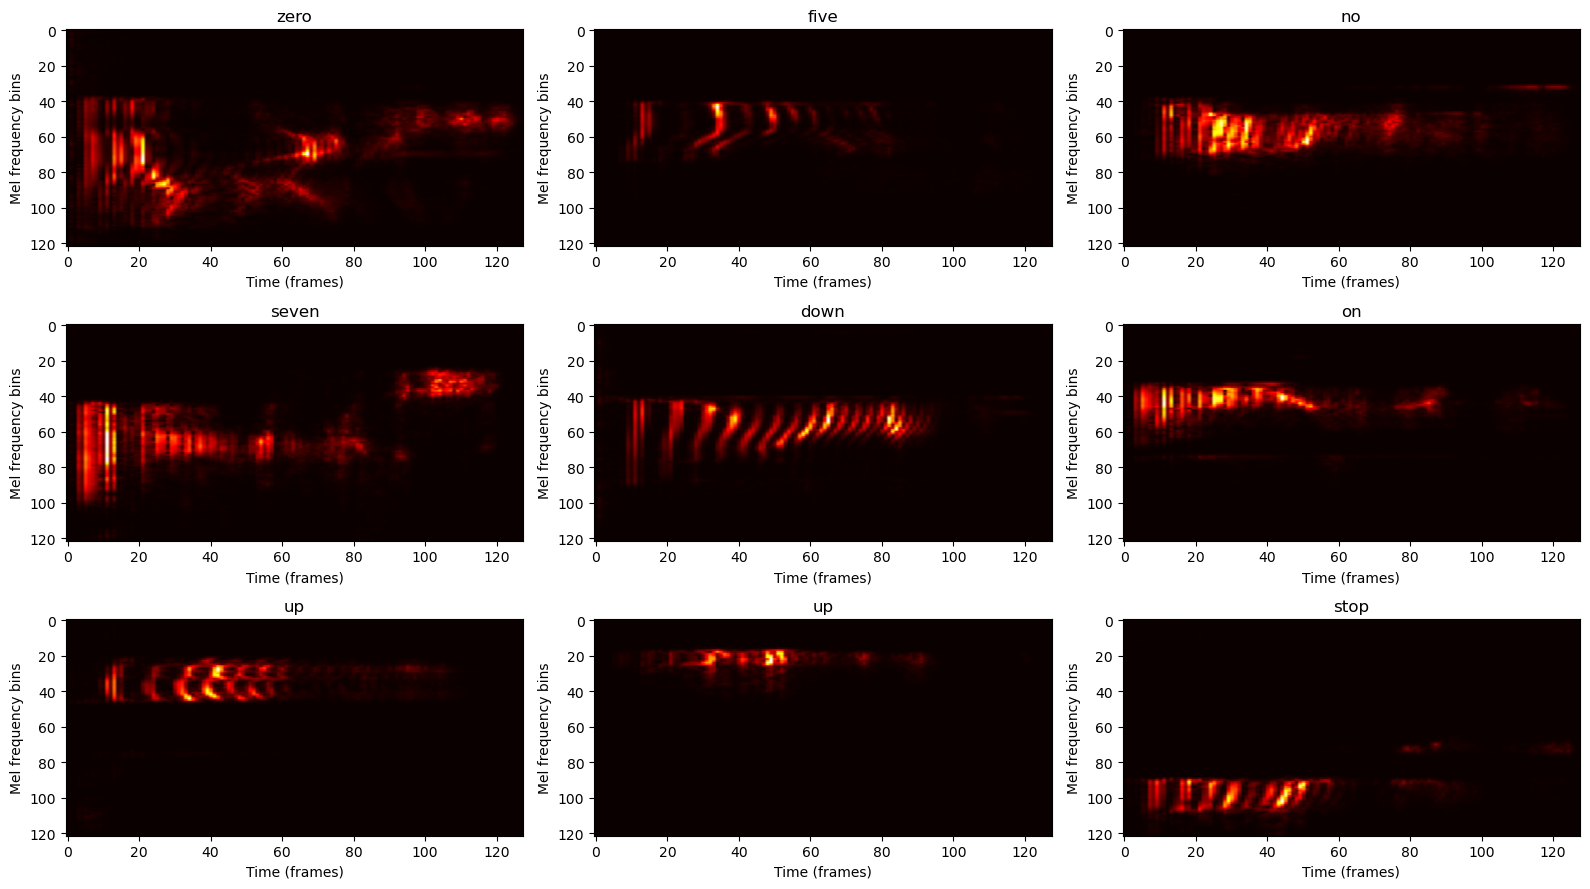

In [42]:
for example_spectrograms, example_spect_labels in train_spectro_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    # Plot the mel spectrogram directly from the example_spectrograms
    ax.imshow(np.squeeze(example_spectrograms[i].numpy()), aspect='auto', cmap='hot')
    # Get the label index (where the value is 1.0)
    label_idx = tf.argmax(example_spect_labels[i]).numpy()
    ax.set_title(label_names[label_idx])
    ax.set_xlabel('Time (frames)')
    ax.set_ylabel('Mel frequency bins')

plt.tight_layout()
plt.show()

## Treenaus

In [44]:
print("Number of classes in dataset:", len(label_names))

Number of classes in dataset: 26


256 konvoluutio ei juurikaan vaikuttanut mallin suoritukseen, mutta hidasti koulutusta

In [53]:
def train_model(train_ds, val_ds, test_ds, label_names, epochs=20, batch_size=32, learning_rate=0.001):
    import keras.layers as layers
    import keras.models as models
    import tensorflow as tf
    import matplotlib.pyplot as plt

    # Prepare datasets with caching and prefetching
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Get input shape and number of labels
    for example_spectrograms, _ in train_ds.take(1):
        input_shape = example_spectrograms.shape[1:]
    num_labels = len(label_names)

    # Normalize the data
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

    # Build the model
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(64, 128),
        norm_layer,
        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax'),
    ])

    print("Aloitetaan mallin koulutus")
    print("Model summary:")
    model.summary()
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    )
    print("Model compiled.")
    print("Training model...")
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=3),
    )

    # Plot training history
    metrics = history.history
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1, 2, 2)
    plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.show()

    # Evaluate the model on the test dataset
    test_results = model.evaluate(test_ds, return_dict=True)
    print("Test results:", test_results)

    return model, history

Aloitetaan mallin koulutus
Model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 64, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 64, 128, 1)     │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 126, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 126, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,752,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,871,901 (10.96 MB)

 Trainable params: 2,871,386 (10.95 MB)

 Non-trainable params: 515 (2.02 KB)

Model compiled.
Training model...
Epoch 1/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 261s 115ms/step - accuracy: 0.2071 - loss: 2.9351 - val_accuracy: 0.5766 - val_loss: 1.4131
Epoch 2/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 256s 113ms/step - accuracy: 0.5416 - loss: 1.4879 - val_accuracy: 0.7879 - val_loss: 0.7083
Epoch 3/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 254s 112ms/step - accuracy: 0.6791 - loss: 1.0363 - val_accuracy: 0.8409 - val_loss: 0.5377
Epoch 4/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 261s 115ms/step - accuracy: 0.7553 - loss: 0.7928 - val_accuracy: 0.8481 - val_loss: 0.5044
Epoch 5/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 254s 112ms/step - accuracy: 0.7977 - loss: 0.6552 - val_accuracy: 0.8856 - val_loss: 0.3867
Epoch 6/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 259s 114ms/step - accuracy: 0.8298 - loss: 0.5540 - val_accuracy: 0.8879 - val_loss: 0.3889
Epoch 7/25
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 256s 113ms/step - accuracy: 0.8513 - loss: 0.4822 - val_accuracy: 0.8838 - val_loss: 0.4207
Epoch 8/25
2269/2269 ━━━━━━━

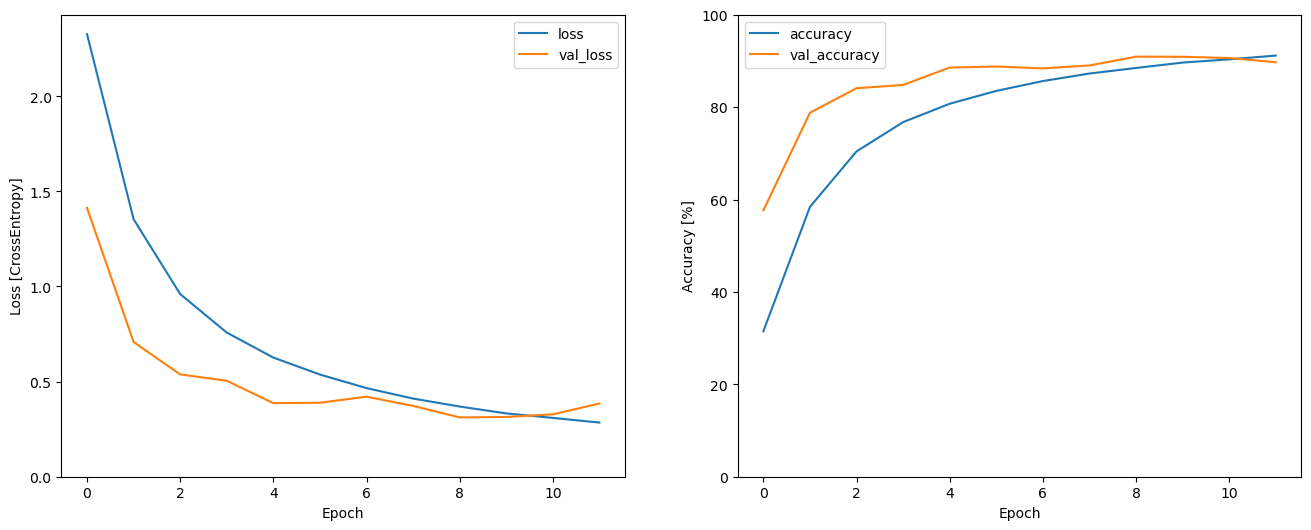

297/297 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.8835 - loss: 0.4275
Test results: {'accuracy': 0.8826315999031067, 'loss': 0.4347975552082062}


In [55]:
trained_model, training_history = train_model(train_spectro_ds, val_spectro_ds, test_spectro_ds, label_names, epochs=25, batch_size=64)

297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


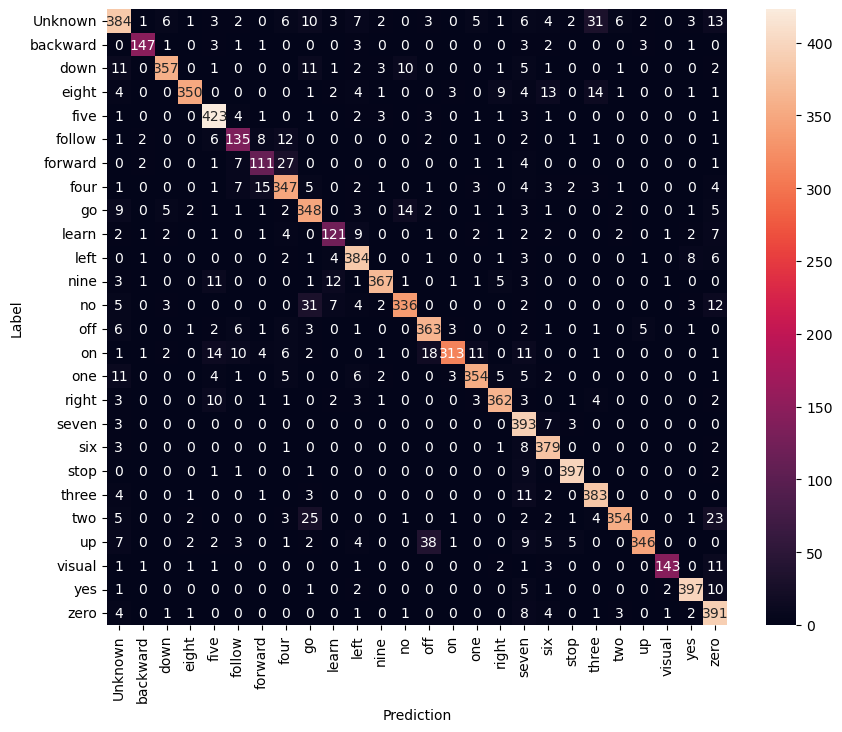

In [56]:
import seaborn as sns

# Confusion matrix for the final model
y_pred = trained_model.predict(test_spectro_ds)
y_true = tf.concat(list(test_spectro_ds.map(lambda s, lab: tf.argmax(lab, axis=1))), axis=0)
y_pred = tf.argmax(y_pred, axis=1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Tallennetaan hyvä malli

In [57]:
# Tallennetaan
trained_model.save('UusiHienoModel.keras')

## Testataan mallia omilla äänitteillä
- Nauhoitimme muutamia äänitiedostoja, ja luokittelimme ne.

In [1]:
import tensorflow as tf
import keras
import keras.utils
import numpy as np
import pathlib

In [59]:
# Load dataset
own_sound_db = keras.utils.audio_dataset_from_directory(
    'omat_aanet',
    batch_size=32,
    shuffle=True,
    seed=42,
    label_mode='categorical',
    labels="inferred",
    output_sequence_length=16000,
)

trained_labels = ['Unknown', 'backward', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
                  'learn', 'left', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'six', 'stop',
                  'three', 'two', 'up', 'visual', 'yes', 'zero']

# Get the inferred class names
inferred_labels = own_sound_db.class_names
print("Inferred labels:", inferred_labels)

# Create a mapping from new labels to indices in the trained labels
label_mapping = {label: trained_labels.index(label) for label in inferred_labels}

# Function to remap labels
def remap_labels(audio, labels):
    # Find the active label index in the new dataset
    active_label_idx = tf.argmax(labels, axis=-1)
    
    # Map the active label index to the corresponding index in the trained labels
    new_label_idx = tf.gather(list(label_mapping.values()), active_label_idx)
    
    # Create a new one-hot encoded label with 26 classes
    new_label = tf.one_hot(new_label_idx, depth=len(trained_labels))
    return audio, new_label

# Apply the remapping to the dataset
own_sound_db = own_sound_db.map(remap_labels, tf.data.AUTOTUNE)

# Verify the remapped labels
for example_audio, example_labels in own_sound_db.take(1):
    print("Example audio shape:", example_audio.shape)
    print("Example labels shape:", example_labels.shape)
    print("Example labels:", example_labels[0])  # Print the label of the first example

def stereo_to_mono(audio, labels):
    # Reduce the last dimension (channels) by averaging, regardless of batch size
    audio = tf.reduce_mean(audio, axis=-1)
    return audio, labels

# Apply the stereo-to-mono conversion
own_sound_db = own_sound_db.map(stereo_to_mono, tf.data.AUTOTUNE)

# Verify the audio shape after conversion
for example_audio, example_labels in own_sound_db.take(1):
    print("Example audio shape after mono conversion:", example_audio.shape)
    print("Example labels shape:", example_labels.shape)


# Create spectrogram dataset
own_sound_spectro_db = make_spectro_dataset(own_sound_db, get_mel_spectrogram)
own_sound_spectro_db = own_sound_spectro_db.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify the spectrogram shape
for example_spectrograms, example_spect_labels in own_sound_spectro_db.take(1):
    print("Example spectrogram shape:", example_spectrograms.shape)
    print("Example labels shape:", example_spect_labels.shape)
    print("Example labels:", example_spect_labels[0])  # Print the label of the first example


# Load the trained model
model = keras.models.load_model('UusiHienoModel.keras')

# Evaluate the model on the new dataset
loss, accuracy = model.evaluate(own_sound_spectro_db, verbose=1)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Found 122 files belonging to 21 classes.
Inferred labels: ['Unknown', 'down', 'eight', 'five', 'four', 'go', 'left', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'six', 'stop', 'three', 'two', 'up', 'yes', 'zero']
Example audio shape: (32, 16000, 1)
Example labels shape: (32, 26)
Example labels: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)
Example audio shape after mono conversion: (32, 16000)
Example labels shape: (32, 26)
Example spectrogram shape: (32, 122, 128, 1)
Example labels shape: (32, 26)
Example labels: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(26,), dtype=float32)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3694 - loss: 2.5915
Loss: 2.5697145462036133, Accuracy: 0.3688524663448334


## Analyysi

#### Valmiin testisetin tunnistus

Ohjelma osaa tunnistaa ääniä testidatasta hyvin. Tarkkuus on n. 85-90 %. Isoimmat erheet näkyvät konfuusiomatriisista. Malli paikoitellen tunnisti sanan "no" sanana "go". Toinen huomattava erhe on sanan "forward" tunnistaminen sanana "four". Kumpikin virhe on ymmärrettävä, koska sanat kuulostavat aika samalta. Sanat "no" ja "forward" tunnistettiin pääasiassa myös oikein kuten matriisista näkee.

#### Omien sanojen tunnistus

Jostain syystä omien sanojen tunnistus ei toimi niin hyvin, kuin setissä olevien.

Tarkkuus 37% on kuitenkin ihan hyvin, kun ottaa huomioon, että luokkia on 26.

Ehkä setistä saatuihin ääniin olisi voinut tehdä jotain augmentaatiota esim. äänen taajuuden muutosta, tai taustakohinaa.

##